In [2]:
import pandas as pd
import numpy as np
import sklearn
import string, re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

# nltk.download('punkt') # if needed
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier

from scipy import sparse
from scipy.sparse import hstack

In [5]:
#Loading the data
train = pd.read_csv('Data\\train_E6oV3lV.csv',
                   sep = ',',
                   header = 0)

toTrain = pd.read_csv('Data\\test_tweets_anuFYb8.csv',
                   sep = ',',
                   header = 0)

toTrain['label'] = None

wholeData = pd.concat([train, toTrain], ignore_index=True, sort = True)
print(wholeData.shape)
labels = wholeData['label'].values
print(labels.shape)

# check data integrity
labelCount = train['label'].value_counts()
balance = labelCount[0] / labelCount[1]
print(balance) # Require some balancing in the data


(49159, 3)
(49159,)
13.256021409455842


In [6]:
#Creating samples
indexTrain = list(range(train.shape[0]))
indexToTrain = np.sort(np.array(list((set(wholeData.index.values) - set(indexTrain)))))

sampleTrain = np.random.choice(indexTrain, size=int(float(len(indexTrain)) * 0.7), replace = False)
sampleTest =  np.sort(np.array(list((set(indexTrain) - set(sampleTrain)))))

reduced = np.random.choice(np.array(list(set(train["id"][(labels[indexTrain] == 0)].index.values) - set(sampleTest))), sum(labels[sampleTrain] == 1))
sampleTrainBal = np.append(reduced, np.array(list(set(train["id"][(labels[indexTrain] == 1)].index.values) - set(sampleTest))))

#reduced2 = np.random.choice(np.array(list(set(train["id"][(labels[indexTrain] == 0)].index.values))), sum(labels[sampleTrain] == 1))
#sampleTrainBalFull = np.append(reduced, np.array(list(train["id"][(labels[indexTrain] == 1)].index.values)))



# check data integrity
labelCount = wholeData['label'][indexTrain].value_counts()
balance = labelCount[0] / labelCount[1]
print(balance)

13.256021409455842


In [12]:
# Functionality functions

# Use a classifier to predict, dispay performances and return f1 score.
def predict_and_score(cls, data, lbs, name = None, ids = None, silent = False):
    pred = cls.predict(data)

    lbs = lbs.astype(int)
    # print(cls.score(data, lbs))
    
    f1_score = sklearn.metrics.f1_score(lbs, pred)
    if not silent:
        print(sklearn.metrics.f1_score(lbs, pred))
        print(sklearn.metrics.confusion_matrix(lbs, pred))
        print(sklearn.metrics.classification_report(lbs, pred))
    return f1_score

# Use a classifier to predict and write prediction in a file.
def predict_and_save(cls, data, name, ids = None):
    pred = cls.predict(data)
    df = pd.DataFrame({'id': ids, 'label': pred})
    df.to_csv(name, sep = ',', index = False)
    return("File {0} saved.".format(name))


# stem words in a setence
def cleanSentence(s, stops):
    st = LancasterStemmer()
    lem = WordNetLemmatizer()
    words = []
    for w in word_tokenize(s):
        if (w not in stops):
            #words.append(st.stem(w))
            words.append(lem.lemmatize(w))
    return(" ".join(words))


def extractEmotion(s, lex):
    inter = set(s.split()).intersection(lex.index)
    return lex.loc[inter, :].mean(axis = 0)

def predict_ambiguous(cls1, cls2, data, data2= None, group = 1):
    pred1 = cls1.predict(data)
    if data2 is None:
        pred2 = cls2.predict(data[pred1 == group])
    else:
        pred2 = cls2.predict(data2[pred1 == group])
    pred1[pred1 == group] = pred2
    return pred1

From here, I will try to keep the code cells independent.
Please run the cells above if you have not. They prepare the data to be used in the following cells.

In [8]:
# First rough approach
data1 = wholeData.copy()

# Data cleaning
# punctRE = re.compile("[a-zA-Z]+" " ")
#data1["tweet"] = data1["tweet"].apply(lambda x: "".join(re.findall(punctRE, x)))

data1["tweet"] = data1["tweet"].apply(lambda x: re.sub("@[\w]*|[^a-zA-Z ]+", '', x))

# vectorise and classify
vectoriser = CountVectorizer()
data1V = vectoriser.fit_transform(data1["tweet"])

# umbalanced
classifier1 = MultinomialNB()
classifier1.fit(data1V[sampleTrain], labels[sampleTrain].astype(int))

print('Train data')
predict_and_score(classifier1, data1V[sampleTrain],  labels[sampleTrain])
print('Test data')
predict_and_score(classifier1, data1V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier1, data1V[indexToTrain], "NB1_umbalanced.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.476363636363636

# balanced
classifier1 = MultinomialNB()
classifier1.fit(data1V[sampleTrainBal], labels[sampleTrainBal].astype(int))

print('Train data')
predict_and_score(classifier1, data1V[sampleTrainBal],  labels[sampleTrainBal])
print('Test data')
predict_and_score(classifier1, data1V[sampleTest], labels[sampleTest])

classifier1.fit(data1V[sampleTrainBal], labels[sampleTrainBal].astype(int))
print('Training new data')
predict_and_save(classifier1, data1V[indexToTrain], "NB1_balanced.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.563380281690141

Train data
0.6653011061040558
[[20744    42]
 [  775   812]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     20786
          1       0.95      0.51      0.67      1587

avg / total       0.96      0.96      0.96     22373

Test data
0.45268292682926825
[[8796  138]
 [ 423  232]]
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      8934
          1       0.63      0.35      0.45       655

avg / total       0.93      0.94      0.93      9589

Training new data
Train data
0.9666977902272021
[[1514   73]
 [  34 1553]]
             precision    recall  f1-score   support

          0       0.98      0.95      0.97      1587
          1       0.96      0.98      0.97      1587

avg / total       0.97      0.97      0.97      3174

Test data
0.43802559414990866
[[7453 1481]
 [  56  599]]
             precision    recall  f1-score   support

          0       0.99      0.83      0.91      893

'File NB1_balanced.csv saved.'

Trying to improve the current model by taking advantage text specific functions.

In [9]:
data2 = wholeData.copy()

## removing @mentions and punctuation
data2["tweet"] = data2["tweet"].apply(lambda x: re.sub("@[\w]*|[^a-zA-Z ]+", '', x))

#print(data["tweet"])
stop_words = set(stopwords.words('english'))
data2["tweet"] = data2["tweet"].apply(lambda x: cleanSentence(x, stop_words))
##/!\ stemming might be a bit long


In [10]:

# vectorise and classify
vectoriser = CountVectorizer()
data2V = vectoriser.fit_transform(data2["tweet"])
# balanced
classifier2 = MultinomialNB()
classifier2.fit(data2V[sampleTrainBal], labels[sampleTrainBal].astype(int))

# check data integrity
labelCount = wholeData['label'][sampleTrainBal].value_counts()
balance = labelCount[0] / labelCount[1]
print(balance)

print('Train data')
predict_and_score(classifier2, data2V[sampleTrainBal],  labels[sampleTrainBal])
print('Test data')
predict_and_score(classifier2, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier2, data2V[indexToTrain], "NB_stem_balanced.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.616279069767442 


1.0
Train data
0.9648020113136391
[[1527   60]
 [  52 1535]]
             precision    recall  f1-score   support

          0       0.97      0.96      0.96      1587
          1       0.96      0.97      0.96      1587

avg / total       0.96      0.96      0.96      3174

Test data
0.4532710280373832
[[7603 1331]
 [  73  582]]
             precision    recall  f1-score   support

          0       0.99      0.85      0.92      8934
          1       0.30      0.89      0.45       655

avg / total       0.94      0.85      0.88      9589

Training new data


'File NB_stem_balanced.csv saved.'

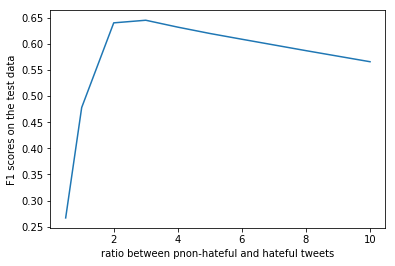

In [48]:
# To overcome the overfitting, the sampling can be adjusted:
# Because the data is unbalanced, the proportion classes play a large role.
# Cross validation can help determine the best proportion to use to both limit over-fiting and improve performances
ratios = [0.5, 1, 2, 3, 4, 5, 6, 8, 10]
scoresf1 = [0] * len(ratios)
i = 0
for ratio in ratios:
    scoref1 = [0] * 10
    for j in range(10):
        trainPos = sampleTrain[labels[sampleTrain] == 1]
        trainNeg = sampleTrain[labels[sampleTrain] == 0]

        dataNeg = np.random.choice(trainNeg, size= round(ratio * len(trainPos)), replace = False)
        dataCV = data2V[np.concatenate((trainPos, dataNeg), 0)]
        clf = MultinomialNB()
        clf.fit(dataCV, labels[np.concatenate((trainPos, dataNeg), axis = 0)].astype(int))
        # f1s = cross_val_score(clf, dataCV, labels[np.concatenate((trainPos, dataNeg), axis = 0)].astype(int), cv=5)
        scoref1[j] =  predict_and_score(clf, data2V[sampleTest], labels[sampleTest].astype(int), silent = True)
    scoresf1[i] = np.mean(scoref1)
    i += 1
    

plt.figure()
plt.xlabel("ratio between pnon-hateful and hateful tweets")
plt.ylabel("F1 scores on the test data")
plt.plot(ratios, scoresf1)
plt.show();



dataNeg = np.random.choice(trainNeg, size= round(3 * len(trainPos)), replace = False)
newTrainBal = np.concatenate((trainPos, dataNeg), 0)

In [50]:

classifier2 = MultinomialNB()
classifier2.fit(data2V[newTrainBal], labels[newTrainBal].astype(int))

# check data integrity
labelCount = wholeData['label'][newTrainBal].value_counts()
balance = labelCount[0] / labelCount[1]
print(balance)

print('Train data')
predict_and_score(classifier2, data2V[newTrainBal],  labels[newTrainBal])
print('Test data')
predict_and_score(classifier2, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier2, data2V[indexToTrain], "NB_stem_balanced_ratio3.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.616279069767442 


3.0
Train data
0.8884195705737417
[[4669   17]
 [ 300 1262]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      4686
          1       0.99      0.81      0.89      1562

avg / total       0.95      0.95      0.95      6248

Test data
0.6587537091988132
[[8685  224]
 [ 236  444]]
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      8909
          1       0.66      0.65      0.66       680

avg / total       0.95      0.95      0.95      9589

Training new data


'File NB_stem_balanced_ratio3.csv saved.'

In [51]:
# use alternative algorithms on stemmed data

classifier3 = RandomForestClassifier(n_estimators = 100)

classifier3.fit(data2V[sampleTrainBal], labels[sampleTrainBal].astype(int))

print('Train data')
predict_and_score(classifier3, data2V[sampleTrainBal],  labels[sampleTrainBal])
print('Test data')
predict_and_score(classifier3, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier3, data2V[indexToTrain], "RF100_stem_balanced.csv", wholeData.iloc[indexToTrain,:]['id'])

classifier3 = RandomForestClassifier(n_estimators = 100)

classifier3.fit(data2V[newTrainBal], labels[newTrainBal].astype(int))

print('Train data')
predict_and_score(classifier3, data2V[newTrainBal],  labels[newTrainBal])
print('Test data')
predict_and_score(classifier3, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier3, data2V[indexToTrain], "RF100_stem_balanced_new_sample.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.609105180533752

Train data
0.99968
[[1561    1]
 [   0 1562]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      1.00      1.00      1562

avg / total       1.00      1.00      1.00      3124

Test data
0.4118457300275482
[[7283 1626]
 [  82  598]]
             precision    recall  f1-score   support

          0       0.99      0.82      0.90      8909
          1       0.27      0.88      0.41       680

avg / total       0.94      0.82      0.86      9589

Training new data
Train data
0.9987179487179487
[[4686    0]
 [   4 1558]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4686
          1       1.00      1.00      1.00      1562

avg / total       1.00      1.00      1.00      6248

Test data
0.6714285714285714
[[8659  250]
 [ 210  470]]
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      8909
          1    

'File RF100_stem_balanced_new_sample.csv saved.'

In [53]:
#Try to improve the RF hyperparameters to avoid overfitting


classifier4 = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [ 10, 20, 100, 200, 500],
    'max_features': [0.3, 'auto', 'log2'],
    'max_depth' :  [5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

classifier4CV = GridSearchCV(estimator = classifier4, param_grid = param_grid, cv= 3)
# {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'n_estimators': 200}
classifier4CV.fit(data2V[newTrainBal], labels[newTrainBal].astype(int))
print(classifier4CV.best_params_)

print('Train data')
predict_and_score(classifier4CV, data2V[newTrainBal],  labels[newTrainBal])
print('Test data')
predict_and_score(classifier4CV, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier4CV, data2V[indexToTrain], "RF_paramCV_stem_balanced.csv", wholeData.iloc[indexToTrain,:]['id'])
#0.45

{'criterion': 'gini', 'max_depth': 8, 'max_features': 0.3, 'n_estimators': 100}
Train data
0.5055970149253731
[[4646   40]
 [1020  542]]
             precision    recall  f1-score   support

          0       0.82      0.99      0.90      4686
          1       0.93      0.35      0.51      1562

avg / total       0.85      0.83      0.80      6248

Test data
0.44202180376610506
[[8803  106]
 [ 457  223]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      8909
          1       0.68      0.33      0.44       680

avg / total       0.93      0.94      0.93      9589

Training new data


'File RF_paramCV_stem_balanced.csv saved.'

Since the random forest does not seem to make the rating to greatly improve, other approaches may be needed, rather than only other algorithms

In [54]:
scoreTest = [0] * 5
score = [0] * 5
i = 0
for k in [ 500, 1000, 2000, 5000, 10000]:
    # Create selector, and apply:
    selector = SelectKBest(mutual_info_classif, k=k)
    # Feature selection on the whole training sample, rather that the balanced one
    selector.fit(data2V[sampleTrain], labels[sampleTrain].astype(int))
    classifier5 = MultinomialNB()

    classifier5.fit(data2V[newTrainBal][:,selector.get_support(indices=True)], labels[newTrainBal].astype(int))

    # print('Train data')
    scoreTest[i] = predict_and_score(classifier5, data2V[newTrainBal][:,selector.get_support(indices=True)],  labels[newTrainBal], silent = True)
    # print('Test data')
    score[i] = predict_and_score(classifier5, data2V[sampleTest][:,selector.get_support(indices=True)], labels[sampleTest], silent = True)
    i += 1


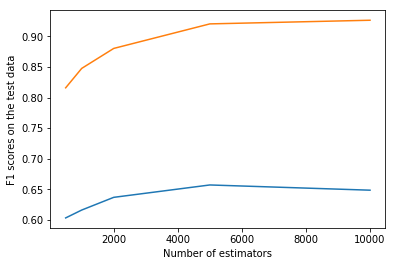

In [56]:

plt.figure()
plt.xlabel("Number of estimators")
plt.ylabel("F1 scores on the test data")
plt.plot([ 500, 1000, 2000, 5000, 10000], score)
plt.plot([ 500, 1000, 2000, 5000, 10000], scoreTest)
plt.show();

In [57]:
kBest = 5000
selector = SelectKBest(mutual_info_classif, k=kBest)
# Feature selection on the whole training sample, rather that the balanced one
selector.fit(data2V[sampleTrainBal], labels[sampleTrainBal].astype(int))
classifier5 = MultinomialNB()

classifier5.fit(data2V[sampleTrainBal][:,selector.get_support(indices=True)], labels[sampleTrainBal].astype(int))

print('Training new data')
predict_and_save(classifier5, data2V[indexToTrain][:,selector.get_support(indices=True)], "NB_feature_sel_stem_balanced.csv", wholeData.iloc[indexToTrain,:]['id'])


Training new data


'File NB_feature_sel_stem_balanced.csv saved.'

New appraoches with lexicons

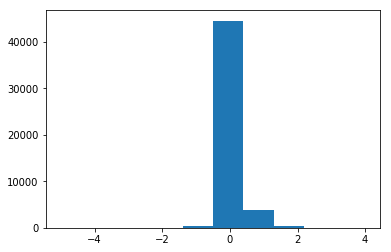

          anger  anticipation   disgust      fear       joy   sadness  \
0      0.368288      0.448039  0.585179  0.696964  0.307466  0.114774   
1      0.313450      0.305425  0.497088  0.183055  0.087149  0.300441   
2      0.036483           NaN  0.455425       NaN       NaN       NaN   
3      0.071944      0.170763  0.653715  0.290777  0.641363  0.723940   
4      0.069792      0.213096  0.862856  0.016300  0.994770       NaN   
5      0.368987      0.075789  0.670443  0.369098  0.682899  0.068925   
6           NaN      0.345652       NaN  0.709802  0.679367  0.368198   
7      0.273956      0.201011  0.541674  0.413752  0.457824  0.061785   
8      0.301275      0.394754  0.412066  0.291494  0.580655  0.232387   
9      0.250447           NaN  0.181909  0.125311  0.283869  0.117751   
10     0.537612      0.470297  0.300371  0.074521  0.121384  0.154122   
11     0.256340      0.260004  0.589363  0.234023  0.561461  0.124603   
12     0.115118      0.193658  0.620664  0.191361  

In [15]:

data3 = wholeData.copy()
# Lexicons

# Emoticon lexicon
# need the raw data to identify emoticons
emoLexi = pd.read_csv('Data\\EmoticonSentimentLexicon.txt',
                   sep = '\t',
                   header = 0)

data3["emoScore"] = 0
data3["emoNb"] = 0

for emoIndex in range(0,emoLexi.shape[0]):
    emo = emoLexi.iloc[emoIndex, 0]
    data3["emoScore"] = data3["emoScore"] + data3["tweet"].apply(lambda x: float(x.count(emo)) * float(emoLexi.iloc[emoIndex, 1]))
    data3["emoNb"] = data3["emoNb"] + data3["tweet"].apply(lambda x: x.count(emo))
    
plt.figure()
plt.hist(data3["emoScore"])
plt.show()

# Hastag lexicon
lexicon = pd.read_csv('Data\\NRC-Hashtag-Emotion-Lexicon-v0.2.txt',
                   sep = '\t',
                   header = 0,
                     names = ['emotion', 'tag', 'score'])

lexicon['tag'] = lexicon['tag'].apply(lambda x: re.sub('\#', '', str(x)))  #removing hastag symbol allow more matches during the search, but also may lead ton aggregation during pivot

# stemming to better generalisation
# lexicon['tag'] = lexicon['tag'].apply(lambda x: st.stem(x))
lex2 = lexicon.pivot_table(index = 'tag', columns = 'emotion', values = 'score') #default aggregation : numpy.mean, works here

# Counting and stemming
## Counting hastags and punctuation
data3["exclamation"] = data3["tweet"].apply(lambda x: len(re.findall("!", x)))
data3["tags"] = data3["tweet"].apply(lambda x: len(re.findall("#", x)))
data3["len"] = data3["tweet"].apply(len)

## removing @mentions and punctuation
data3["tweet"] = data3["tweet"].apply(lambda x: re.sub("@[\w]*|[^a-zA-Z ]+", '', x))

data4 = data3['tweet'][:].apply(lambda x: extractEmotion(x, lex2))
data4 = pd.concat([data4, data3[["exclamation","tags","len", "emoScore", "emoNb"]]], axis = 1)
# data4['emoScore'] = data4['emoScore'] + (0 - min(data4['emoScore']))
# print(data4)

<Figure size 432x288 with 0 Axes>

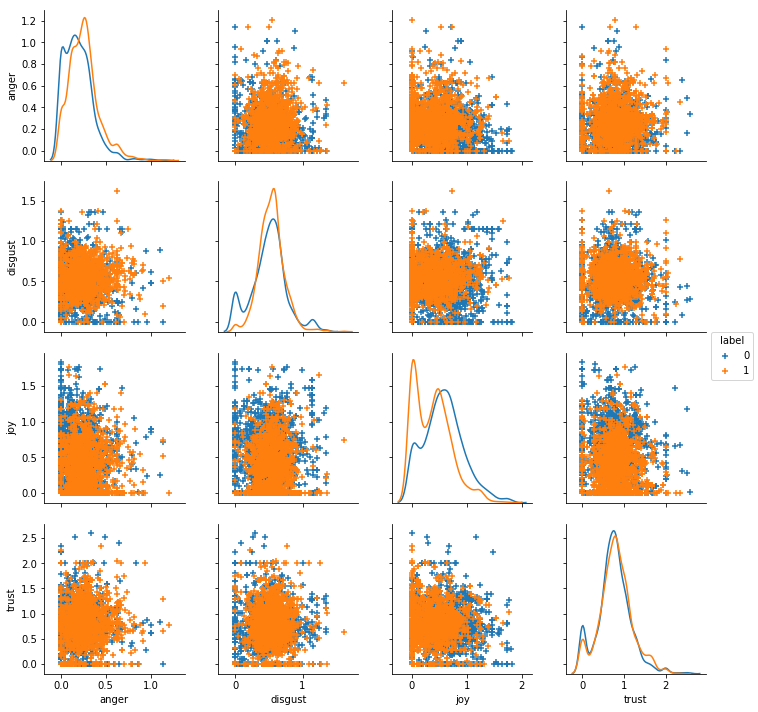

In [98]:
# plotting emotions in the different classes

#for emotion in ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]:
#    plt.figure()
#    sns.kdeplot(data4[emotion][labels == 0], shade=True, color="r")
#    sns.kdeplot(data4[emotion][labels == 1], shade=True, color="b")
#    plt.show()

labels2 = [-1  if str(x) == 'None' else x for x in labels2]
df =  pd.concat([data4[["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]].fillna(0), pd.DataFrame(labels2, columns=["label"])] , axis = 1)

plt.figure()
sns.pairplot(df.iloc[sampleTrainBal,:], vars= ["anger", "disgust",  "joy", "trust"],hue = "label", markers="+",diag_kind="kde")
plt.show();


In [16]:
#print(data4full)
classifier6 = RandomForestClassifier(n_estimators = 100)
#classifier6 = MultinomialNB()

data44 = sparse.csr_matrix(np.nan_to_num(np.matrix(data4)))
classifier6.fit(data44[sampleTrainBal], labels[sampleTrainBal].astype(int))
    
print('Train data')
predict_and_score(classifier6, data44[sampleTrainBal],  labels[sampleTrainBal])
print('Test data')
predict_and_score(classifier6,data44[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier6, data44[indexToTrain], "NB_emolexicon.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.342581423401689

Train data
1.0
[[1562    0]
 [   0 1562]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      1.00      1.00      1562

avg / total       1.00      1.00      1.00      3124

Test data
0.29084783829309374
[[6545 2364]
 [ 162  518]]
             precision    recall  f1-score   support

          0       0.98      0.73      0.84      8909
          1       0.18      0.76      0.29       680

avg / total       0.92      0.74      0.80      9589

Training new data


'File NB_emolexicon.csv saved.'

In [101]:
# train model on word data:
classifier21 = MultinomialNB()
classifier21.fit(data2V[newTrainBal], labels[newTrainBal].astype(int))
prediction1 = classifier21.predict(data2V[sampleTrain])
# selection of ambiguous terms:
newTrain = sampleTrain[prediction1 == 1]
# train a new model with lexicon data to deal with ambiguous data
classifier22 = RandomForestClassifier(n_estimators = 50)
# classifier22 = MultinomialNB()
classifier22.fit(data2V[newTrain], labels[newTrain].astype(int))


predAmbiTr = predict_ambiguous(classifier21, classifier22, data2V[sampleTrain], data2V[sampleTrain])
print("Train data")
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), predAmbiTr))

print("Test data")
predAmbi = predict_ambiguous(classifier21, classifier22, data2V[sampleTest], data2V[sampleTest])
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), predAmbi))



Train data
1 classifier
0.7747084100675261
             precision    recall  f1-score   support

          0       0.99      0.98      0.98     20811
          1       0.74      0.81      0.77      1562

avg / total       0.97      0.97      0.97     22373

[[20377   434]
 [  300  1262]]
2 classifiers
0.8937677053824363
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     20811
          1       1.00      0.81      0.89      1562

avg / total       0.99      0.99      0.99     22373

[[20811     0]
 [  300  1262]]
Test data
1 classifier
0.6587537091988132
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      8909
          1       0.66      0.65      0.66       680

avg / total       0.95      0.95      0.95      9589

[[8685  224]
 [ 236  444]]
2 classifiers
0.6137040714995035
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      8909
        

In [102]:
print('saving submission')
name = "2_round_classification_NB_RF_new_sampling_and_full_train_sampling.csv"
ids =  wholeData.iloc[indexToTrain,:]['id']
pred = predict_ambiguous(classifier21, classifier22, data2V[indexToTrain], data2V[indexToTrain])
df = pd.DataFrame({'id': ids, 'label': pred})
df.to_csv(name, sep = ',', index = False)

saving submission


In [107]:
#same appraoch but with RF classifiers only
# train model on word data:
# train model on word data:
classifier21 = RandomForestClassifier(n_estimators = 100)
classifier21.fit(data2V[newTrainBal], labels[newTrainBal].astype(int))
prediction1 = classifier21.predict(data2V[sampleTrain])
# selection of ambiguous terms:
newTrain = sampleTrain[prediction1 == 1]
# train a new model with lexicon data to deal with ambiguous data
classifier22 = RandomForestClassifier(n_estimators = 100)
# classifier22 = MultinomialNB()
classifier22.fit(data2V[newTrain], labels[newTrain].astype(int))

predAmbiTr = predict_ambiguous(classifier21, classifier22, data2V[sampleTrain], data2V[sampleTrain])
print("Train data")
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), predAmbiTr))

print("Test data")
predAmbi = predict_ambiguous(classifier21, classifier22, data2V[sampleTest], data2V[sampleTest])
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), predAmbi))

print('saving submission')
name = "2_round_classification_RF_RF_new_sampling_and_full_train_sampling.csv"
ids =  wholeData.iloc[indexToTrain,:]['id']
pred = predict_ambiguous(classifier21, classifier22, data2V[indexToTrain], data2V[indexToTrain])
df = pd.DataFrame({'id': ids, 'label': pred})
df.to_csv(name, sep = ',', index = False)



Train data
1 classifier
0.9983969220904136
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20811
          1       1.00      1.00      1.00      1562

avg / total       1.00      1.00      1.00     22373

[[20811     0]
 [    5  1557]]
2 classifiers
0.9983969220904136
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20811
          1       1.00      1.00      1.00      1562

avg / total       1.00      1.00      1.00     22373

[[20811     0]
 [    5  1557]]
Test data
1 classifier
0.997789240972734
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8909
          1       1.00      1.00      1.00       680

avg / total       1.00      1.00      1.00      9589

[[8909    0]
 [   3  677]]
2 classifiers
0.997789240972734
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8909
          

In [18]:
#same appraoch but with RF classifiers and inversed classifier
# train model on word data:
classifier21 = RandomForestClassifier(n_estimators = 100)
classifier21.fit(data2V[indexTrain], labels[indexTrain].astype(int))
prediction1 = classifier21.predict(data2V[sampleTrain])
# selection of ambiguous terms:
newTrain = sampleTrain[prediction1 == 0]
# train a new model with lexicon data to deal with ambiguous data
classifier22 = RandomForestClassifier(n_estimators = 100)
# classifier22 = MultinomialNB()
classifier22.fit(data2V[newTrain], labels[newTrain].astype(int))

predAmbiTr = predict_ambiguous(classifier21, classifier22, data2V[sampleTrain], data2V[sampleTrain], 0)
print("Train data")
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), predAmbiTr))

print("Test data")
predAmbi = predict_ambiguous(classifier21, classifier22, data2V[sampleTest], data2V[sampleTest], 0)
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), predAmbi))

print('saving submission')
name = "2_round_classification_RF_RF_indexTrain_and_full_train_sampling.csv"
ids =  wholeData.iloc[indexToTrain,:]['id']
pred = predict_ambiguous(classifier21, classifier22, data2V[indexToTrain], data2V[indexToTrain], 0)
df = pd.DataFrame({'id': ids, 'label': pred})
df.to_csv(name, sep = ',', index = False)

#this is the one

Train data
1 classifier
0.9974731522425774
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20786
          1       1.00      0.99      1.00      1587

avg / total       1.00      1.00      1.00     22373

[[20786     0]
 [    8  1579]]
2 classifiers
0.9981060606060606
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20786
          1       1.00      1.00      1.00      1587

avg / total       1.00      1.00      1.00     22373

[[20786     0]
 [    6  1581]]
Test data
1 classifier
0.9984709480122325
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8934
          1       1.00      1.00      1.00       655

avg / total       1.00      1.00      1.00      9589

[[8934    0]
 [   2  653]]
2 classifiers
0.9984709480122325
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8934
        

In [19]:

# train model on word data:
classifier21 = RandomForestClassifier(n_estimators = 100)
classifier21.fit(data2V[indexTrain], labels[indexTrain].astype(int))
prediction1 = classifier21.predict(data2V[sampleTrain])
# selection of ambiguous terms:
newTrain = sampleTrain[prediction1 == 1]
# train a new model with lexicon data to deal with ambiguous data
classifier22 = RandomForestClassifier(n_estimators = 100)
# classifier22 = MultinomialNB()
classifier22.fit(data2V[newTrain], labels[newTrain].astype(int))

predAmbiTr = predict_ambiguous(classifier21, classifier22, data2V[sampleTrain], data2V[sampleTrain], 1)
print("Train data")
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), predAmbiTr))

print("Test data")
predAmbi = predict_ambiguous(classifier21, classifier22, data2V[sampleTest], data2V[sampleTest], 1)
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), classifier21.predict(data2V[sampleTest])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), predAmbi))

print('saving submission')
name = "2_round_classification_RF_RF_indexTrain_and_full_train_sampling_reversed1.csv"
ids =  wholeData.iloc[indexToTrain,:]['id']
pred = predict_ambiguous(classifier21, classifier22, data2V[indexToTrain], data2V[indexToTrain], 1)
df = pd.DataFrame({'id': ids, 'label': pred})
df.to_csv(name, sep = ',', index = False)

Train data
1 classifier
0.9981060606060606
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20786
          1       1.00      1.00      1.00      1587

avg / total       1.00      1.00      1.00     22373

[[20786     0]
 [    6  1581]]
2 classifiers
0.9981060606060606
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20786
          1       1.00      1.00      1.00      1587

avg / total       1.00      1.00      1.00     22373

[[20786     0]
 [    6  1581]]
Test data
1 classifier
0.9984709480122325
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8934
          1       1.00      1.00      1.00       655

avg / total       1.00      1.00      1.00      9589

[[8934    0]
 [   2  653]]
2 classifiers
0.9984709480122325
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8934
        

In [19]:
# extract only meaningful terms (without stemming)

data5 = wholeData.copy()

## removing @mentions and punctuation
data5["tweet"] = data5["tweet"].apply(lambda x: re.sub("@[\w]*|[^a-zA-Z ]+", '', x))

#print(data["tweet"])
stop_words = set(stopwords.words('english'))
data5["tweet"] = data5["tweet"].apply(lambda x: cleanSentence(x, stop_words))


vectoriser = CountVectorizer()
data5V = vectoriser.fit_transform(data5["tweet"])

data5h = sparse.csr_matrix(labels[sampleTrain].astype(int)) @ data5V[sampleTrain]
sums = sparse.csr_matrix(data5V[sampleTrain].sum(axis = 1))
data5nh = [1] * len(sampleTrainBal)

  (0, 781)	1
  (0, 61270)	1
  (0, 786)	2
  (0, 61268)	1
  (0, 779)	1
  (0, 21732)	1
  (0, 21734)	1
  (0, 64606)	2
  (0, 67170)	2
  (0, 9904)	2
  (0, 32178)	2
  (0, 30609)	1
  (0, 30605)	1
  (0, 50943)	1
  (0, 3009)	1
  (0, 3982)	1
  (0, 3981)	1
  (0, 42181)	2
  (0, 63373)	1
  (0, 3010)	1
  (0, 12373)	2
  (0, 25388)	2
  (0, 34367)	1
  (0, 46889)	1
  (0, 18686)	1
  :	:
  (0, 22328)	15
  (0, 9795)	7
  (0, 39192)	50
  (0, 167)	82
  (0, 8548)	12
  (0, 11284)	24
  (0, 39645)	2
  (0, 18823)	1
  (0, 48463)	19
  (0, 48460)	19
  (0, 18820)	3
  (0, 61375)	11
  (0, 63749)	17
  (0, 25185)	26
  (0, 68814)	99
  (0, 68813)	115
  (0, 54604)	79
  (0, 62418)	13
  (0, 47387)	73
  (0, 47386)	73
  (0, 29710)	111
  (0, 63484)	399
  (0, 31829)	153
  (0, 66107)	10
  (0, 62140)	572


In [20]:
s = [False] * sums.shape[0]
j = 0
for i in data5h.indices:
    s[j] = (data5h.getcol(i) == sums[j])
    j += 1
ss = np.sort(s)

# j = 0
# s = [False] * sums.shape[0]
# for i in ss:
#     print(sums[j,0])
#     print(data5h[0,i])
#     s[j] = (data5h[0,i] == sums[j,0])
#     j += 1
# print(ss)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:226: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)


[<1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>, <1x1 sparse matrix

In [21]:
### Boosting method may work better

classifier6 = AdaBoostClassifier(
    n_estimators=50)
scores = cross_val_score(classifier6, data2V[sampleTrainBal], labels[sampleTrainBal].astype(int), scoring= "f1")
print(scores)
classifier6.fit( data2V[sampleTrainBal], labels[sampleTrainBal].astype(int), )


print('Train data')
predict_and_score(classifier6, data2V[sampleTrainBal],  labels[sampleTrainBal])
print('Test data')
predict_and_score(classifier6, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(classifier6, data2V[indexToTrain], "Adaboost_balanced.csv", wholeData.iloc[indexToTrain,:]['id'])
# 0.487752928647497

[0.77563452 0.73716632 0.75622969]
Train data
0.7880658436213992
[[1357  205]
 [ 413 1149]]
             precision    recall  f1-score   support

          0       0.77      0.87      0.81      1562
          1       0.85      0.74      0.79      1562

avg / total       0.81      0.80      0.80      3124

Test data
0.38152130625248903
[[7557 1352]
 [ 201  479]]
             precision    recall  f1-score   support

          0       0.97      0.85      0.91      8909
          1       0.26      0.70      0.38       680

avg / total       0.92      0.84      0.87      9589

Training new data


'File Adaboost_balanced.csv saved.'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal number of features : 71331
71331
[0.         0.00381924 0.01137099 0.016341   0.01882793 0.02381436
 0.02749612 0.0273889  0.02851721 0.03210171 0.04047915 0.04150258
 0.04492112 0.04707457 0.04811497 0.04802831 0.05378072 0.05483675
 0.0594195  0.06405211 0.06507406 0.07165297 0.07830348 0.08036074
 0.08558191 0.08877756 0.09089615 0.09622296 0.10016993 0.10544093
 0.1064013  0.11258998 0.12074017 0.1235287  0.13065986 0.13460464
 0.14379417 0.1494399  0.15105227 0.15291571 0.15934647 0.16414186
 0.16690662 0.17271367 0.17340209 0.17707709 0.18027643 0.18273202
 0.18533685 0.18578161 0.18556367 0.19104157 0.19190577 0.19362604
 0.1962177  0.19807341 0.20056707 0.20018947 0.20516503 0.20553209
 0.21046443 0.21217188 0.21468797 0.215043   0.21585322 0.2155359
 0.21567656 0.21544919 0.21703387 0.21942524 0.22670735 0.22906232
 0.2311625  0.23191011 0.23375031 0.23427863 0.23481671 0.23664505
 0.23774352 0.23839905 0.24059814 0.24297747 0.24464284 0.24498532
 0.24556246 0.24874273

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


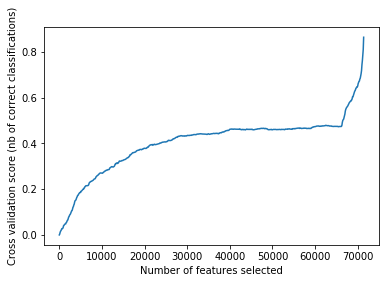

Train data
0.9697548551416747
[[1506   56]
 [  39 1523]]
             precision    recall  f1-score   support

          0       0.97      0.96      0.97      1562
          1       0.96      0.98      0.97      1562

avg / total       0.97      0.97      0.97      3124

Test data
0.4691452663855883
[[7592 1317]
 [  68  612]]
             precision    recall  f1-score   support

          0       0.99      0.85      0.92      8909
          1       0.32      0.90      0.47       680

avg / total       0.94      0.86      0.88      9589

Training new data


'File RFECV.csv saved.'

In [22]:
nsteps = 100
rfecv = RFECV(estimator=classifier2, step=nsteps, cv= 3,
              scoring='f1')
rfecv.fit(data2V[sampleTrainBal], labels[sampleTrainBal].astype(int))

print("Optimal number of features : %d" % rfecv.n_features_)
print(len(rfecv.support_))
print(str(rfecv.grid_scores_))
#print(len())

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, nsteps *len(rfecv.grid_scores_) + 1, nsteps), rfecv.grid_scores_)
plt.show()


print('Train data')
predict_and_score(rfecv, data2V[sampleTrainBal],  labels[sampleTrainBal])
print('Test data')
predict_and_score(rfecv, data2V[sampleTest], labels[sampleTest])

print('Training new data')
predict_and_save(rfecv, data2V[indexToTrain], "RFECV.csv", wholeData.iloc[indexToTrain,:]['id'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\dtypes\dtypes.py:271: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


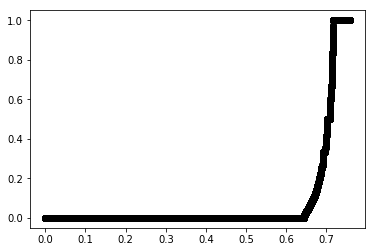

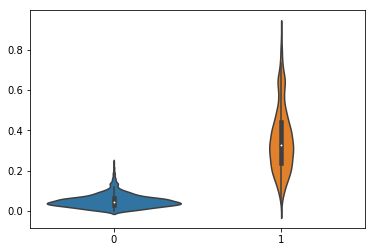

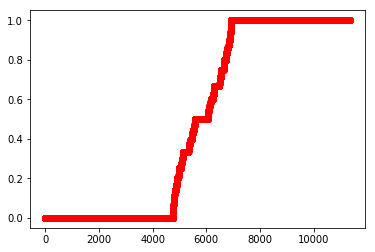

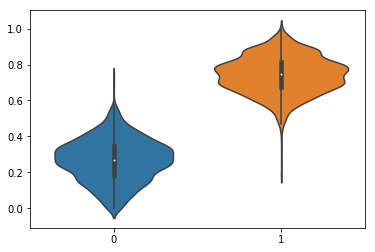

In [23]:

# Creating subsets
hateful = data2V[labels == 1]
nonHateful = data2V[labels == 0]

hatefulScore = hateful.sum(axis = 0)
nonHatefulScore = nonHateful.sum(axis = 0)
hatefulness = hatefulScore / (hatefulScore + nonHatefulScore)

plt.plot(np.array(range(hatefulness.shape[1]),ndmin = 2)/(hatefulness.shape[1]), np.sort(hatefulness), 'o', color = 'black');
plt.show;
# purity of classes:
tweetPurity = (sparse.csr_matrix(data2V[sampleTrainBal])  * hatefulness.transpose()) / data2V[sampleTrainBal].sum(axis = 1)
plt.figure()
sns.violinplot(labels[sampleTrainBal].flatten(), tweetPurity.flat )

hatefulSampleBal = data2V[sampleTrainBal][labels[sampleTrainBal] == 1]
nonHatefulSampleBal = data2V[sampleTrainBal][labels[sampleTrainBal] == 0]

hatefulScoreSampleBal = hatefulSampleBal.sum(axis = 0)
nonHatefulScoreSampleBal = nonHatefulSampleBal.sum(axis = 0)
hatefulnessSampleBal = hatefulScoreSampleBal / (hatefulScoreSampleBal + nonHatefulScoreSampleBal)

plt.figure()
plt.plot(np.array(range(hatefulnessSampleBal.shape[1]),ndmin = 2), np.sort(hatefulnessSampleBal), 'o', color = 'red');
plt.show;
# purity of classes:
tweetPuritySampleBal = (sparse.csr_matrix(data2V[sampleTrainBal])  * hatefulnessSampleBal.transpose()) / data2V[sampleTrainBal].sum(axis = 1)
plt.figure()
sns.violinplot(labels[sampleTrainBal].flatten(), tweetPuritySampleBal.flat )


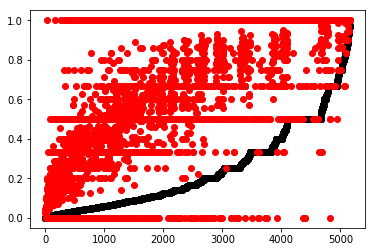

In [24]:
#Compare word hatefulness with the two samples:
# select only features with non zero or non 1 scores
hatefulnessComplex = [0< h<1 for h in hatefulness.flat]

# use rank to sort both vectors the same way
rankHateful = np.unravel_index(np.argsort(hatefulness[0,hatefulnessComplex]),dims = hatefulness[0,hatefulnessComplex].shape)
plt.figure()
plt.plot(np.array(range(len(rankHateful[1][0])),ndmin = 2), hatefulness[0,hatefulnessComplex][rankHateful] , 'o', color = 'black');
plt.plot(np.array(range(len(rankHateful[1][0])),ndmin = 2), hatefulnessSampleBal[0,hatefulnessComplex][rankHateful] , 'o', color = 'red');
plt.show;


In [25]:
# select non ambiguous features:
hatefulnessComplex = [not(h<0) for h in hatefulness.flat]
print(data2V.shape)
print(type(data2V))
data2Vred = data2V[:,[i for i, x in enumerate(hatefulnessComplex) if x]]
print(data2V is data2Vred)
print(data2Vred.shape)
print(type(data2Vred))

# train model on word data:
classifier21 = MultinomialNB()
classifier21.fit(data2Vred[sampleTrainBal], labels[sampleTrainBal].astype(int))
prediction1 = classifier21.predict(data2Vred[sampleTrain])
# selection of ambiguous terms:
newTrain = sampleTrain[prediction1 == 1]
# train a new model with lexicon data to deal with ambiguous data
classifier22 = RandomForestClassifier(n_estimators = 50)
# classifier22 = MultinomialNB()
classifier22.fit(data2Vred[sampleTrain], labels[sampleTrain].astype(int))

def predict_ambiguous(cls1, cls2, data, data2= None, group = 1):
    pred1 = cls1.predict(data)
    if data2 is None:
        pred2 = cls2.predict(data[pred1 == group])
    else:
        pred2 = cls2.predict(data2[pred1 == group])
    pred1[pred1 == group] = pred2
    return pred1

print(data2Vred[sampleTrain].shape)
predAmbiTr = predict_ambiguous(classifier21, classifier22, data2Vred[sampleTrain], data2Vred[sampleTrain])
print("Train data")
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), classifier21.predict(data2Vred[sampleTrain])))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), classifier21.predict(data2Vred[sampleTrain])))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), classifier21.predict(data2V[sampleTrain])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.classification_report(labels[sampleTrain].astype(int), predAmbiTr))
print(sklearn.metrics.confusion_matrix(labels[sampleTrain].astype(int), predAmbiTr))

print("Test data")
predAmbi = predict_ambiguous(classifier21, classifier22, data2Vred[sampleTest], data2Vred[sampleTest])
print("1 classifier")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), classifier21.predict(data2Vred[sampleTest])))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), classifier21.predict(data2Vred[sampleTest])))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), classifier21.predict(data2Vred[sampleTest])))
print("2 classifiers")
print(sklearn.metrics.f1_score(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.classification_report(labels[sampleTest].astype(int), predAmbi))
print(sklearn.metrics.confusion_matrix(labels[sampleTest].astype(int), predAmbi))

(49159, 71331)
<class 'scipy.sparse.csr.csr_matrix'>
False
(49159, 71331)
<class 'scipy.sparse.csr.csr_matrix'>
(22373, 71331)
Train data
1 classifier
0.5002463458696008
             precision    recall  f1-score   support

          0       1.00      0.86      0.92     20811
          1       0.34      0.98      0.50      1562

avg / total       0.95      0.86      0.89     22373

[[17807  3004]
 [   39  1523]]
2 classifiers
0.9850552306692657
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     20811
          1       1.00      0.97      0.99      1562

avg / total       1.00      1.00      1.00     22373

[[20811     0]
 [   46  1516]]
Test data
1 classifier
0.4691452663855883
             precision    recall  f1-score   support

          0       0.99      0.85      0.92      8909
          1       0.32      0.90      0.47       680

avg / total       0.94      0.86      0.88      9589

[[7592 1317]
 [  68  612]]
2 classifiers
0.62252

In [26]:
print('saving submission')
name = "2_round_classification_NB_RF_new_features.csv"
ids =  wholeData.iloc[indexToTrain,:]['id']
pred = predict_ambiguous(classifier21, classifier22, data2V[indexToTrain], data2V[indexToTrain])
df = pd.DataFrame({'id': ids, 'label': pred})
df.to_csv(name, sep = ',', index = False)

saving submission
